## Imports

In [1]:
import pickle
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV, RepeatedKFold
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.multioutput import RegressorChain
from IPython.display import display

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.4f}'.format

In [2]:
from sklearn import __version__
__version__

'1.0.2'

## Variables de Control

In [3]:
SHOULD_SAMPLE = False
SAMPLE_PER = 0.25
DATASET_NAME = 'Alemana'
TRAIN_MODELS = False
N_FOLDS = 10
RAND_STATE = 42
TEST_SIZE = 0.2
REMOVE_COLUMNS = True
GRIDSEARCH = False
POST_GS = False
N_REPEATS = 3

### Modelos

In [4]:
estimators = {'SGD': RegressorChain(base_estimator=SGDRegressor(max_iter=1000, tol=1e-3, random_state=RAND_STATE), random_state=RAND_STATE),
              'Linear': RegressorChain(base_estimator=LinearRegression(), random_state=RAND_STATE),
              'SVR': RegressorChain(base_estimator=SVR(), random_state=RAND_STATE),
              'RandomForest': RandomForestRegressor(random_state=RAND_STATE),
              'GradientBoosting': RegressorChain(base_estimator=GradientBoostingRegressor(random_state=RAND_STATE), random_state=RAND_STATE),
              'MLP': MLPRegressor(random_state=RAND_STATE)}

## Funciones

In [5]:
def load_pickle(filename: str):
    infile = open(filename, 'rb')
    var = pickle.load(infile, encoding='latin1')
    infile.close()
    return var

def save_to_pickle(filename: str, obj):
    with open(filename, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def squash(df):
    df_dict = {}
    for x in range(df.shape[0]):
        serie = df.iloc[x,:]
        for index, value in serie.items():
            df_dict.update({f'{serie.name} {index}': f'{value}'})
            
    return pd.DataFrame.from_dict(df_dict, orient='index').T

## Carga de datos

In [6]:
df = pd.read_csv('./data/Alemana.csv', index_col=0)
df.head().T

,0,1,2,3,4
Load Farm pini,0.0000,0.0000,0.0000,0.0000,0.0000
Load Farm voltage,1.0005,1.0005,1.0005,1.0005,1.0005
Load Farm terminal,BB Farm,BB Farm,BB Farm,BB Farm,BB Farm
Load Industry pini,0.0000,0.0000,0.0000,0.0000,0.0000
Load Industry voltage,1.0000,1.0000,1.0000,1.0000,1.0000
Load Industry terminal,MV,MV,MV,MV,MV
Load Market pini,0.0000,0.0000,0.0000,0.0000,0.0000
Load Market voltage,1.0004,1.0004,1.0004,1.0004,1.0004
Load Market terminal,BB Market,BB Market,BB Market,BB Market,BB Market
Load Residential Complex pini,0.0000,0.0000,0.0000,0.0000,0.0000


## Preprocesado

In [7]:
df.shape

(61194, 68)

In [8]:
df = df.drop_duplicates()
df.shape

(61194, 68)

## Análisis

### Descripción estadística

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Load Farm pini,43628.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Load Farm voltage,43628.0000,1.0005,0.0001,1.0005,1.0005,1.0005,1.0006,1.0007
Load Industry pini,43626.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Load Industry voltage,43626.0000,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
Load Market pini,52412.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Load Market voltage,52412.0000,1.0004,0.0001,1.0002,1.0004,1.0004,1.0004,1.0006
Load Residential Complex pini,61194.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Load Residential Complex voltage,61194.0000,1.0003,0.0001,1.0001,1.0002,1.0003,1.0003,1.0004
ConventionalGenerator Diesel Engine cst_disp,61194.0000,3.0263,0.4694,1.6215,2.7757,3.2873,3.3797,3.4173
ConventionalGenerator Diesel Engine loading,61194.0000,5.8834,1.4611,2.4448,5.4808,6.5411,6.6145,8.3181


In [10]:
df.describe().T.drop(columns=['count']).to_latex('{}_stats.tex'.format(DATASET_NAME))

### Matriz de valores faltantes

<AxesSubplot:>

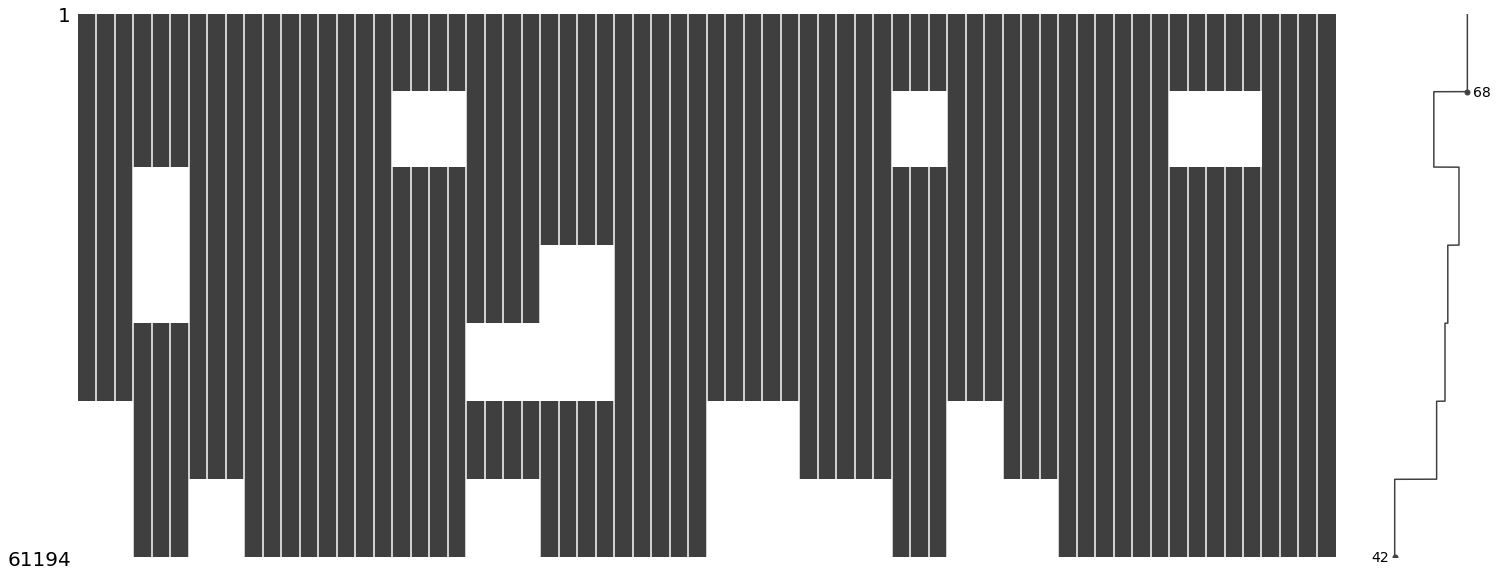

In [11]:
msno.matrix(df)

### Dendrograma de valores faltantes

<AxesSubplot:>

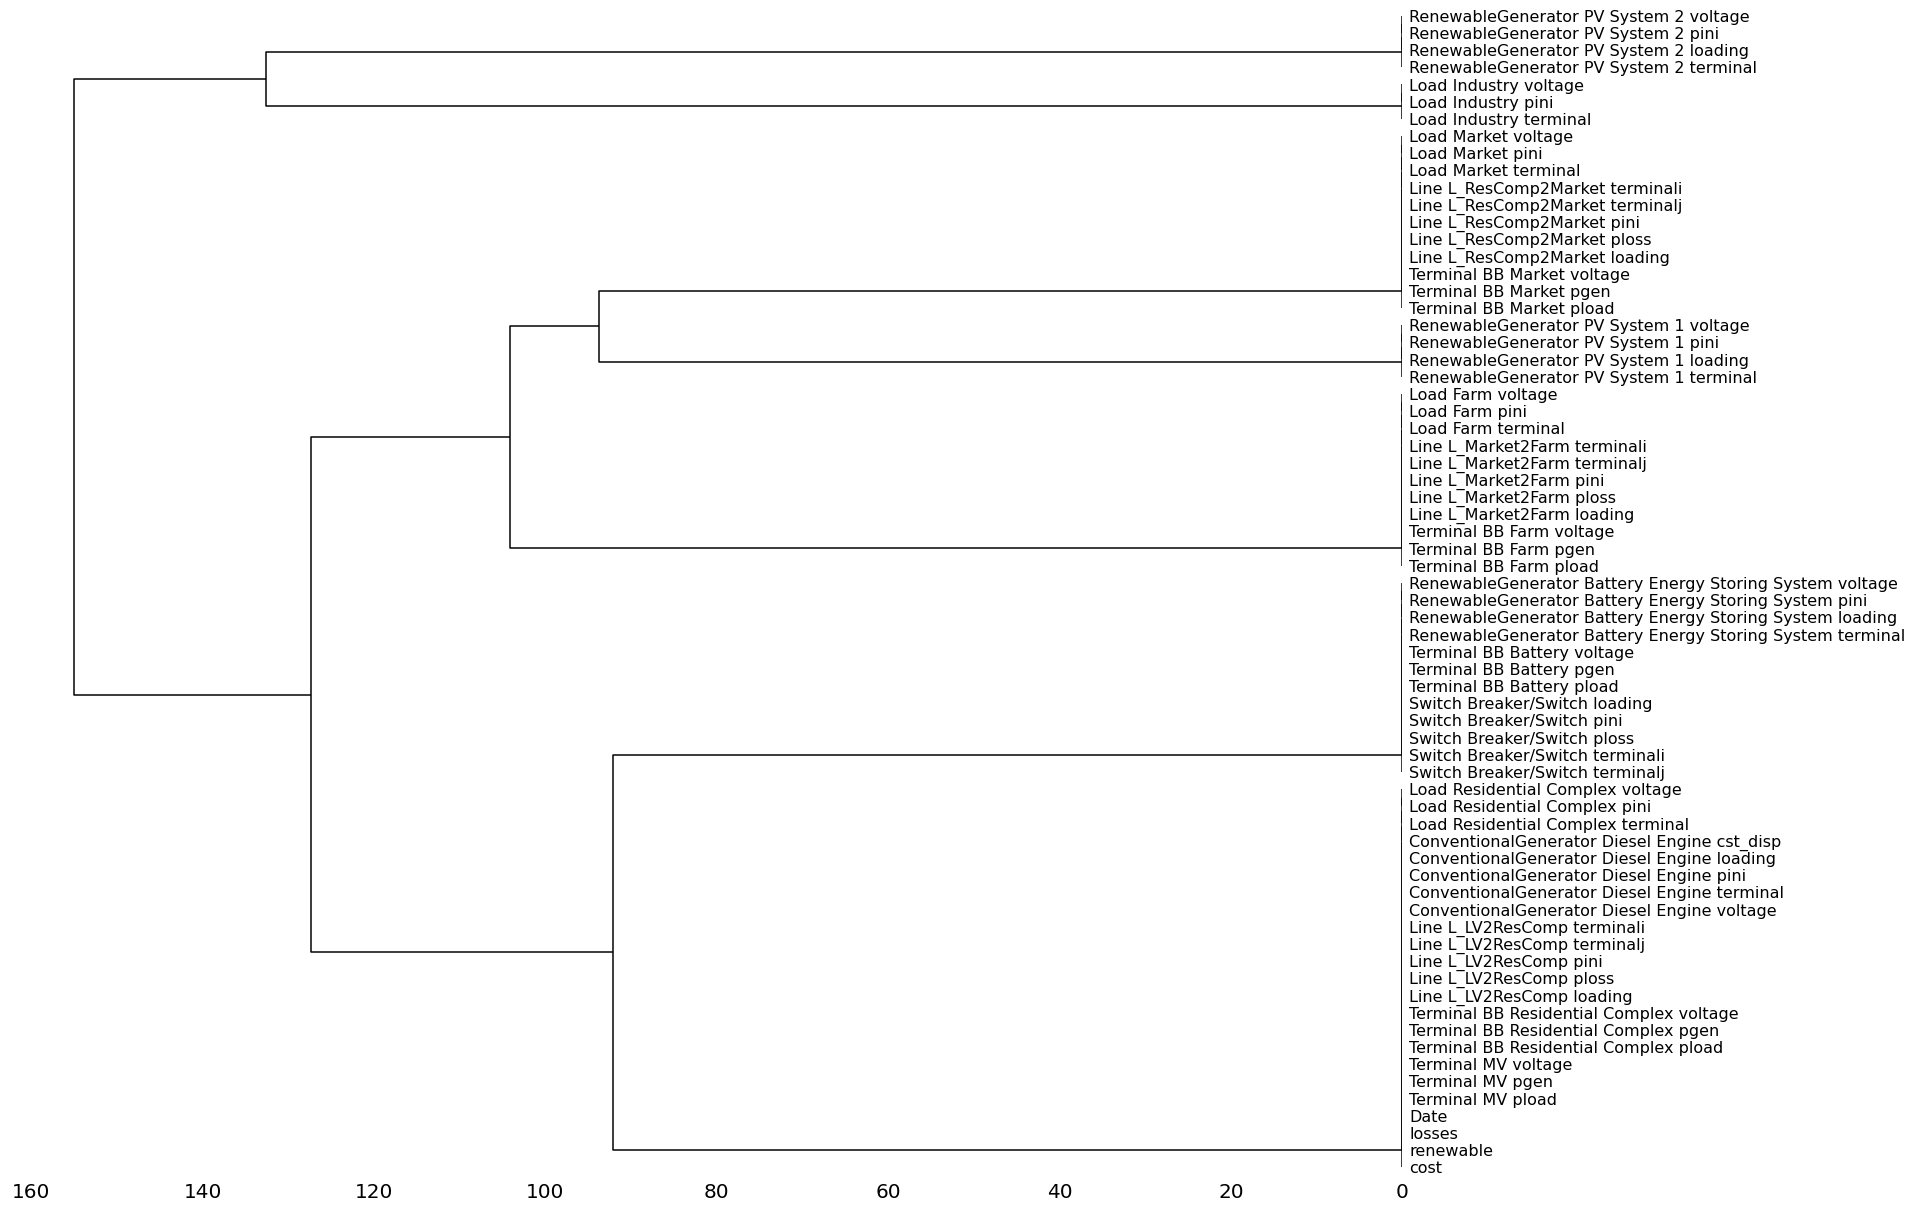

In [12]:
msno.dendrogram(df)

### Correlación entre valores faltantes

<AxesSubplot:>

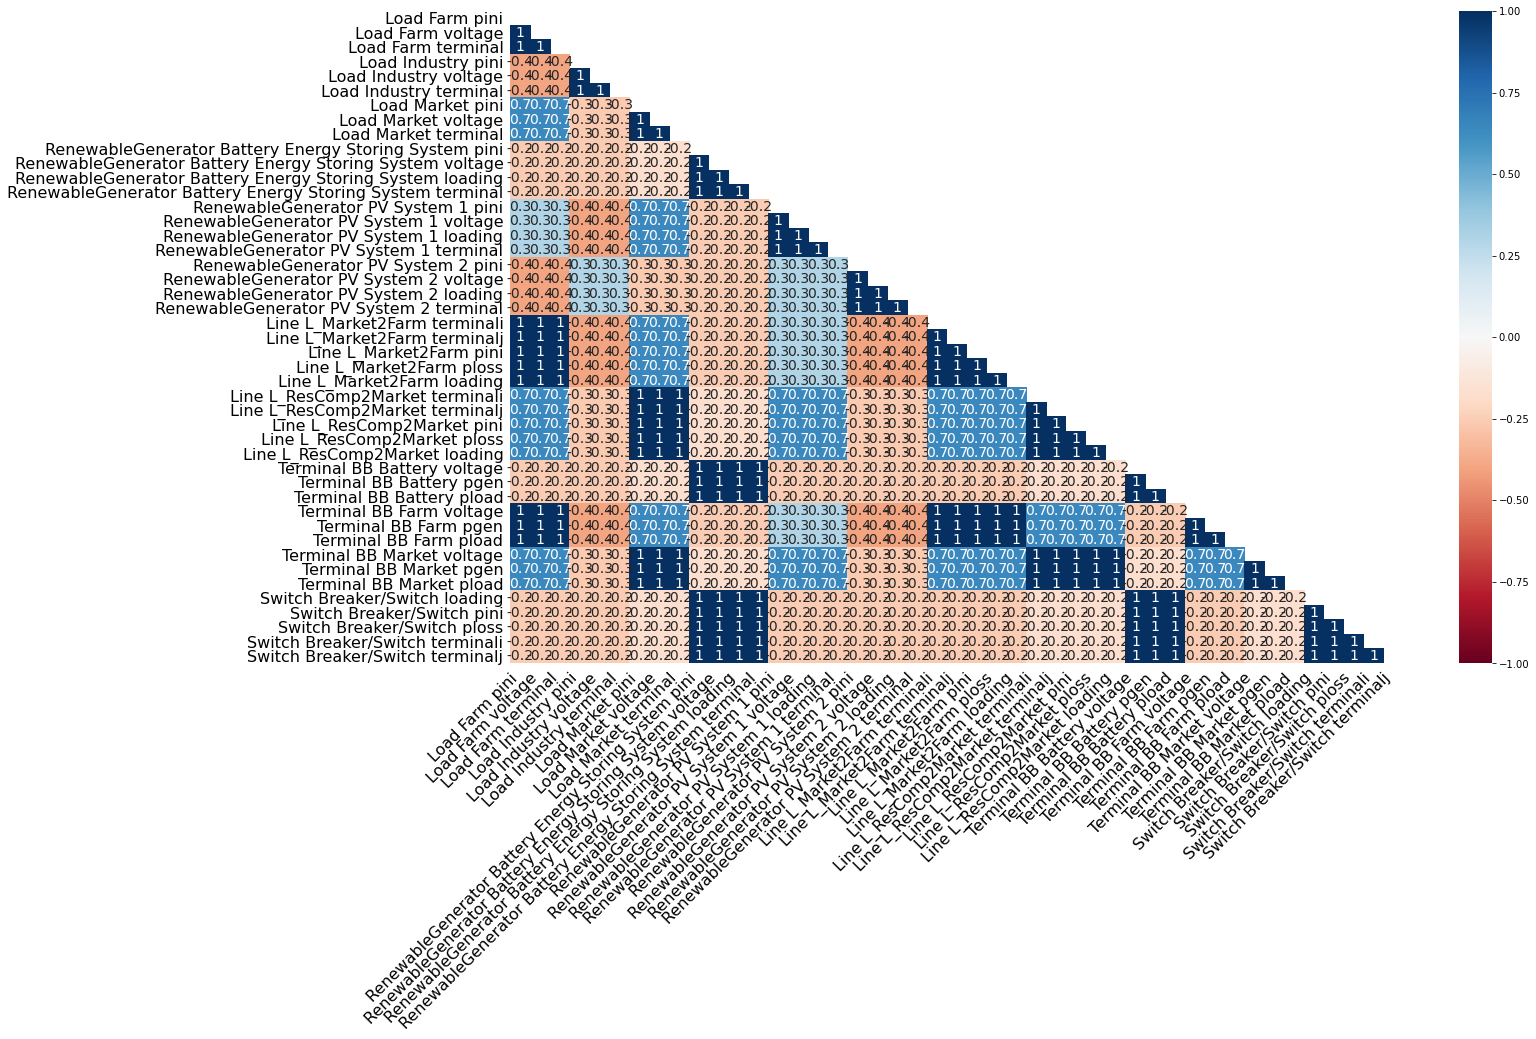

In [13]:
msno.heatmap(df)

### Procesado de valores faltantes

Valores faltantes reemplazados por valor neutro de los campos (0)

In [14]:
df = df.replace(np.NaN, 0)

Se compreuba que el dataset está completo (No hay valores faltantes)

<AxesSubplot:>

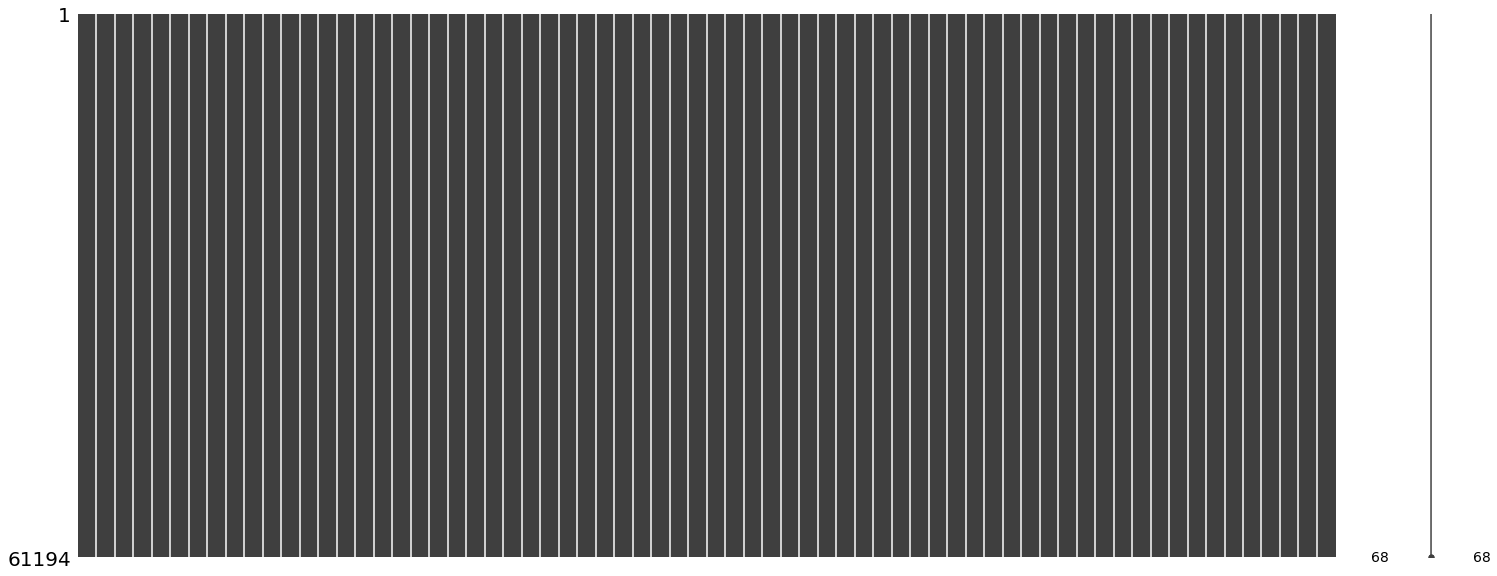

In [15]:
msno.matrix(df)

### Eliminación de columnas con baja varianza

In [16]:
df.shape

(61194, 68)

In [17]:
selector = VarianceThreshold()
columns = df.columns.drop(['Date', 'renewable', 'cost', 'losses']).drop([x for x in df.columns if 'terminal' in x])
selector.fit(df.drop(columns=['Date', 'renewable', 'cost', 'losses']).drop(columns=[x for x in df.columns if 'terminal' in x]))

VarianceThreshold()

In [18]:
selected_columns = list()
removed_columns = list()
for column, selected in zip(columns, selector.get_support()):
    if selected:
        selected_columns.append(column)
    else:
        removed_columns.append(column)

print('Columnas removidas por baja varianza:\n', removed_columns)

Columnas removidas por baja varianza:
 ['Load Farm pini', 'Load Industry pini', 'Load Market pini', 'Load Residential Complex pini', 'Terminal BB Battery pload', 'Terminal BB Farm pgen', 'Terminal BB Farm pload', 'Terminal BB Market pload', 'Terminal BB Residential Complex pgen', 'Terminal BB Residential Complex pload', 'Terminal MV pload', 'Switch Breaker/Switch loading']


In [19]:
if REMOVE_COLUMNS:
    df = df.drop(columns=removed_columns)
    df.shape

### Correlación entre valores del datase

In [20]:
corr_df = df.drop(columns=['losses', 'renewable', 'cost']).corr().round(decimals=2).dropna(how='all', axis=1).dropna(how='all', axis=0)

In [21]:
corr_df.shape

(36, 36)

<AxesSubplot:>

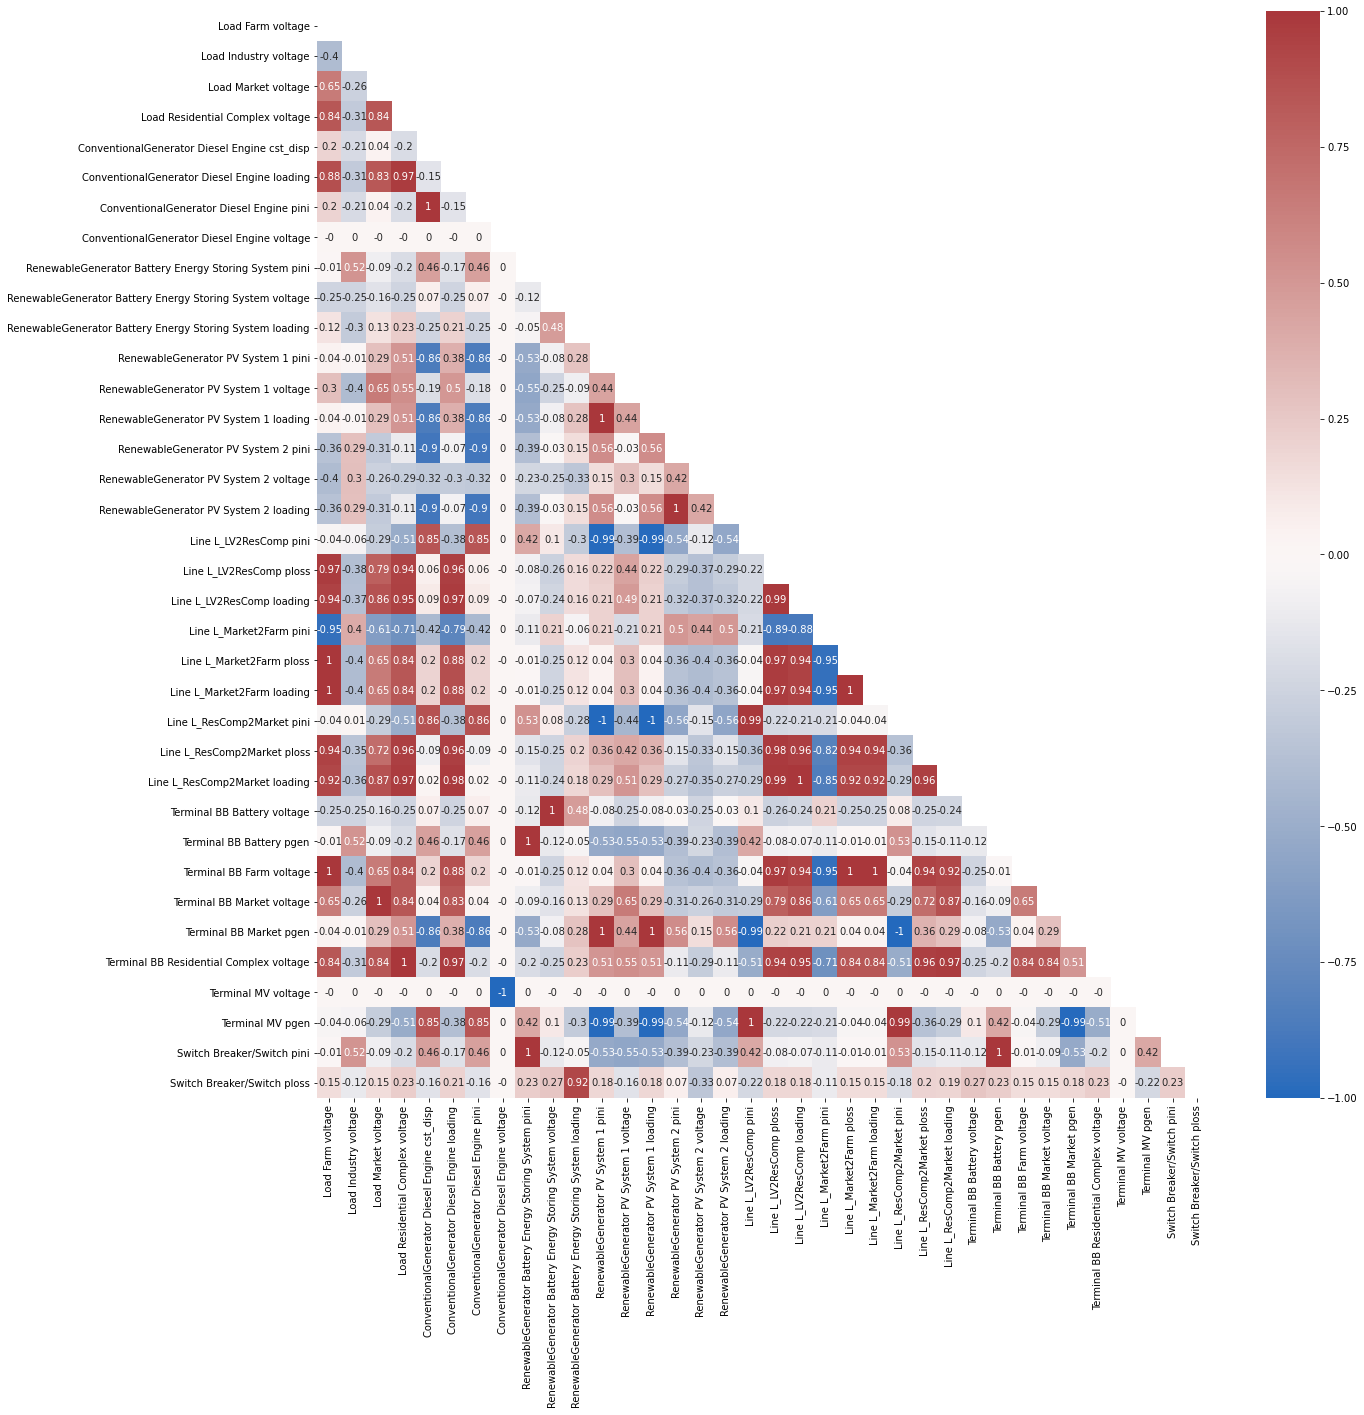

In [22]:
fig, ax = plt.subplots(figsize=(20,20))
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_df, ax=ax, annot=True, mask=mask, cmap=sns.color_palette("vlag", as_cmap=True))

In [23]:
#figure, axis = plt.subplots(5, 6, figsize=(20,20))
#columns = df.columns.drop(['Date', 'renewable', 'cost', 'losses']).drop([x for x in df.columns if 'terminal' in x])

#for i in range(0,5):
#    for j in range(0,6):
#        sns.histplot(df, x=columns[i * 5 + j], bins=20, ax=axis[i, j])

#plt.show()


## Modelado

In [24]:
if SHOULD_SAMPLE:
    dataset = df.sample(frac=SAMPLE_PER, random_state = RAND_STATE)
else:
    dataset = df

# Shuffle dataset
dataset = dataset.sample(frac=1, random_state=RAND_STATE).reset_index(drop=True)

X = dataset.drop(columns=['Date', 'renewable', 'cost', 'losses']).drop(columns=[x for x in dataset.columns if 'terminal' in x])
y = dataset[['losses', 'renewable', 'cost']]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X, X_test, y, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)

# Hacer kfold, shuffle dataset
cv = KFold(n_splits=N_FOLDS, random_state=RAND_STATE, shuffle=True)

model_scores = {}

if TRAIN_MODELS:
    for key, estimator in estimators.items():
        model_scores[key] = cross_validate(estimator, X, y, cv=cv, scoring=('explained_variance', 'neg_mean_squared_error', 'r2'), n_jobs=-1, return_estimator=True)
    save_to_pickle('{}_Pred_Score.pickle'.format(DATASET_NAME), model_scores)

else:
    model_scores = load_pickle('{}_Pred_Score.pickle'.format(DATASET_NAME))

In [25]:
model_scores_df =  pd.DataFrame.from_dict(model_scores).drop('estimator')
model_scores_df = model_scores_df.apply(lambda x: x.apply(lambda y: np.mean(y)), axis=1)
model_scores_df

,SGD,Linear,SVR,RandomForest,GradientBoosting,MLP
fit_time,0.3033,0.4089,245.1571,38.7459,47.1853,6.1437
score_time,0.0122,0.0146,5.9335,0.0898,0.0311,0.0131
test_explained_variance,0.7106,0.7450,0.5188,0.9910,0.9260,-2.2005
test_neg_mean_squared_error,-0.0231,-0.0196,-0.0200,-0.0005,-0.0076,-0.0135
test_r2,0.7105,0.7449,0.2468,0.9909,0.9259,-2.6060


In [26]:
filter = {}
cv_scores = {}
test_keys = []
model_keys = list(model_scores.keys())

for key, item in model_scores.items():
    item_keys = [x for x in item.keys() if 'test' in x]
    test_keys = item_keys
    filter[key] = {}
    for ikey in item_keys:
        filter[key][ikey] = item[ikey]

for test in test_keys:
    cv_scores[test] = {}
    for model in model_keys:
        cv_scores[test][model] = filter[model][test]

In [27]:
test_scores = {}

for key, item in model_scores.items():
    test_scores[key] = list()
    for estimator in model_scores[key]['estimator']:
        test_scores[key].append(estimator.score(X_test, y_test))



### Resultados

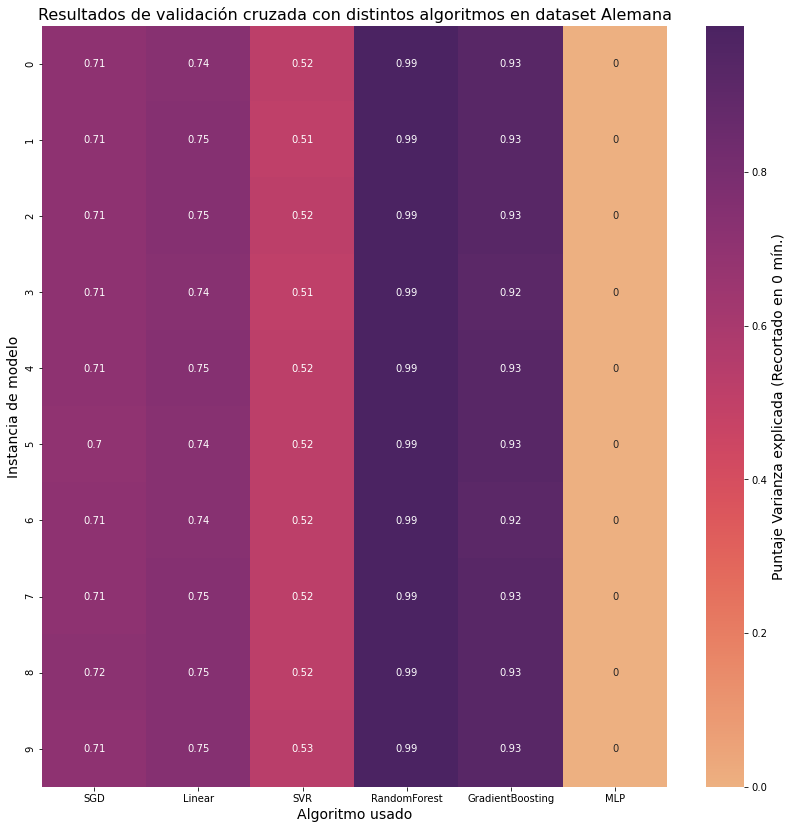

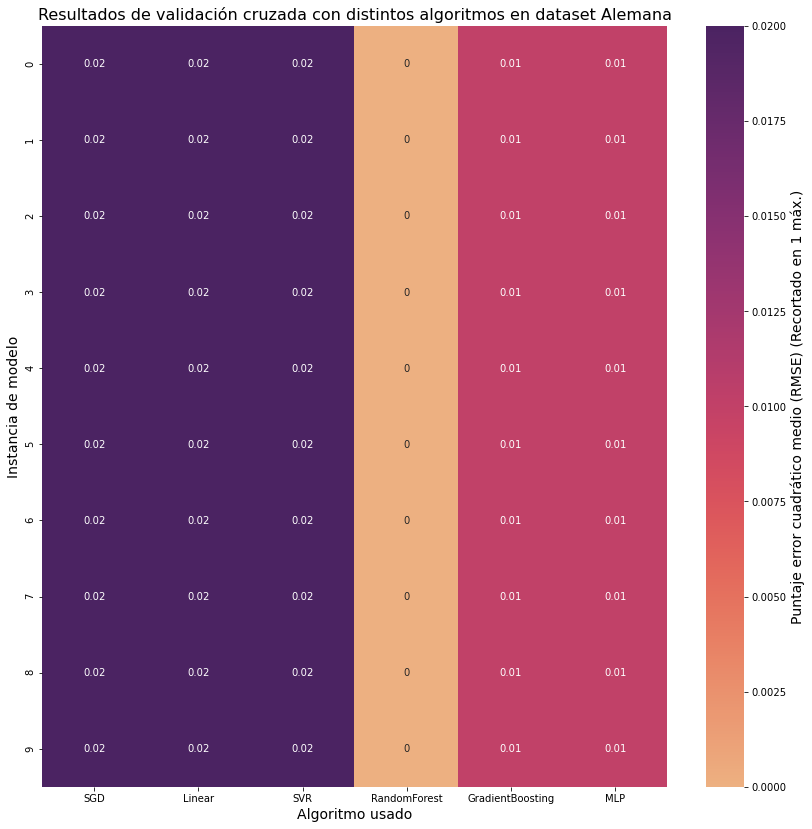

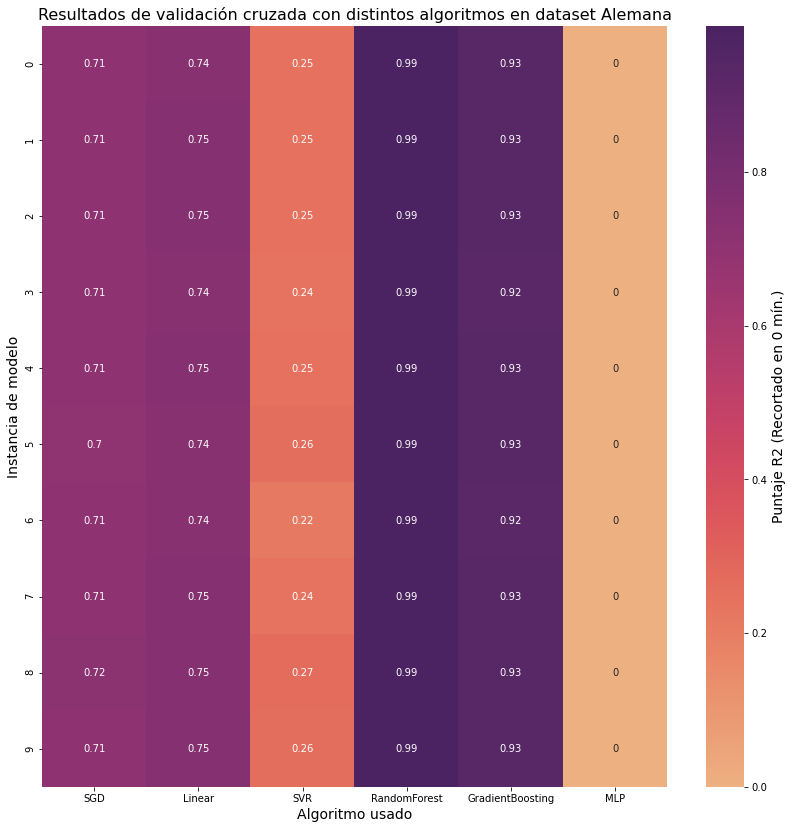

In [28]:
test_label_dict = {'test_explained_variance': 'Puntaje Varianza explicada (Recortado en 0 mín.)',
                   'test_neg_mean_squared_error': 'Puntaje error cuadrático medio (RMSE) (Recortado en 1 máx.)',
                   'test_r2': 'Puntaje R2 (Recortado en 0 mín.)'}

for test, results in cv_scores.items():
    fig, ax = plt.subplots(figsize=(14, 14))
    fig_df = pd.DataFrame.from_dict(results)

    if 'neg' in test:
        fig_df = fig_df.apply(lambda x: x.apply(lambda y: -y))

    ax = sns.heatmap(fig_df.clip(lower=0, upper=1).round(decimals=2), annot = True, cmap=sns.color_palette('flare', as_cmap=True), cbar_kws={'label': test_label_dict[test]})
    ax.set_title('Resultados de validación cruzada con distintos algoritmos en dataset {}'.format(DATASET_NAME), fontsize = 16)
    ax.set_xlabel('Algoritmo usado', fontsize = 14)
    ax.set_ylabel('Instancia de modelo', fontsize = 14)
    ax.figure.axes[-1].yaxis.label.set_size(14)

    plt.show()

In [29]:
test_scores_df = pd.DataFrame.from_dict(test_scores)
test_scores_df.describe().T

,count,mean,std,min,25%,50%,75%,max
SGD,10.0000,0.7094,0.0013,0.7070,0.7087,0.7098,0.7101,0.7108
Linear,10.0000,0.7425,0.0002,0.7421,0.7424,0.7426,0.7426,0.7426
SVR,10.0000,0.2438,0.0003,0.2434,0.2435,0.2439,0.2440,0.2442
RandomForest,10.0000,0.9909,0.0002,0.9906,0.9908,0.9909,0.9910,0.9912
GradientBoosting,10.0000,0.9246,0.0011,0.9224,0.9241,0.9246,0.9254,0.9260
MLP,10.0000,-2.6105,1.3969,-4.7431,-3.5527,-2.2971,-1.5249,-0.6777


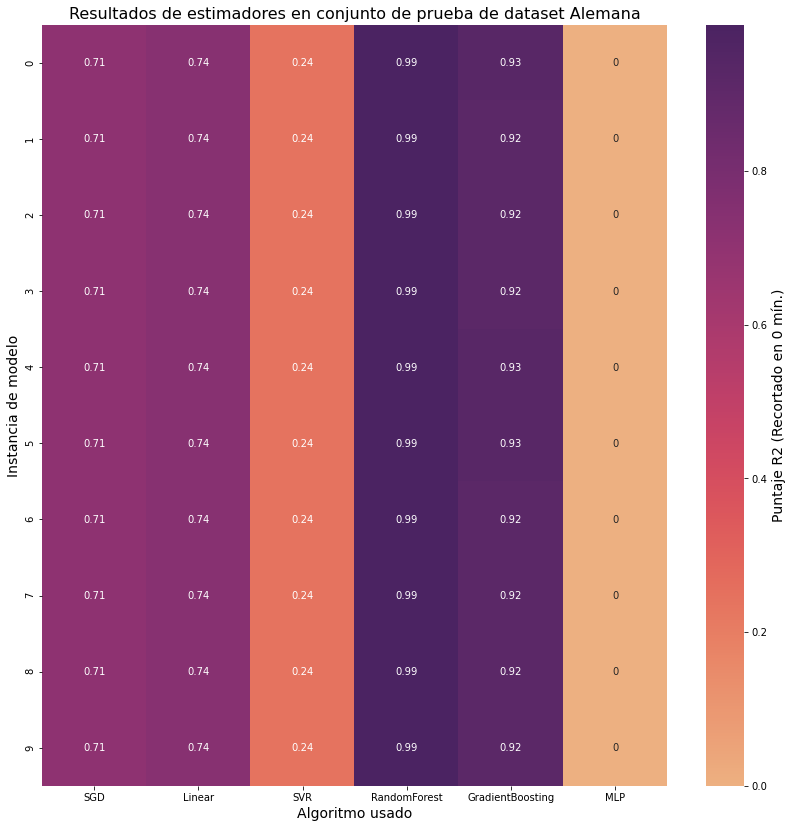

In [30]:
fig, ax = plt.subplots(figsize=(14, 14))

ax = sns.heatmap(test_scores_df.clip(lower=0, upper=1).round(decimals=2), annot = True, cmap=sns.color_palette('flare', as_cmap=True), cbar_kws={'label': 'Puntaje R2 (Recortado en 0 mín.)'})
ax.set_title('Resultados de estimadores en conjunto de prueba de dataset {}'.format(DATASET_NAME), fontsize = 16)
ax.set_xlabel('Algoritmo usado', fontsize = 14)
ax.set_ylabel('Instancia de modelo', fontsize = 14)
ax.figure.axes[-1].yaxis.label.set_size(14)

plt.show()

### Grid Search

In [31]:
estimators = {'SGD': RegressorChain(base_estimator=SGDRegressor(max_iter=1000, random_state=RAND_STATE), random_state=RAND_STATE),
              'Linear': RegressorChain(base_estimator=LinearRegression(), random_state=RAND_STATE),
              'SVR': RegressorChain(base_estimator=SVR(), random_state=RAND_STATE),
              'RandomForest': RandomForestRegressor(random_state=RAND_STATE),
              'GradientBoosting': RegressorChain(base_estimator=GradientBoostingRegressor(random_state=RAND_STATE), random_state=RAND_STATE),
              'MLP': MLPRegressor(random_state=RAND_STATE)}

In [32]:
# Spaces
hyper_spaces = {
    'SGD': {
        'base_estimator__loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
        'base_estimator__penalty': ['l2', 'l1', 'elasticnet'],
        'base_estimator__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    },
    'Linear': {
        'base_estimator__fit_intercept': [True, False]
    },
    'SVR': {
        'base_estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'base_estimator__gamma': ['scale', 'auto'],
         'base_estimator__C': [0.1, 1, 10, 100]
    },
    'RandomForest': {
        'n_estimators': [10, 50, 100, 200, 400],
        'criterion': ['mse', 'mae'],
        'max_depth': [None, 10, 100, 200],
    },
    'GradientBoosting': {
        'base_estimator__loss': ['ls', 'lad', 'huber', 'quantile'],
        'base_estimator__learning_rate': [0.01, 0.1, 1],
        'base_estimator__n_estimators': [50, 100, 200],
        'base_estimator__criterion': ['friedman_mse', 'mse', 'mae']
    },
    'MLP': {
        'hidden_layer_sizes': [(10,), (20,), (40,), (10, 10,), (20, 10), (40, 10,)],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'activation': ['logistic', 'tanh'],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'batch_size': ['auto', 50, 100, 200, 400]
    }
}

if GRIDSEARCH:
    cv = RepeatedKFold(n_splits=N_FOLDS, n_repeats=N_REPEATS, random_state=RAND_STATE)
    X = dataset.drop(columns=['Date', 'renewable', 'cost', 'losses']).drop(columns=[x for x in dataset.columns if 'terminal' in x])
    y = dataset[['losses', 'renewable', 'cost']]

    results_dfs = {}

    for name, model in estimators.items():
        start_time = time.time()
        search = GridSearchCV(model, hyper_spaces[name], scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)
        result = search.fit(X, y)
        results_dfs[name] = pd.DataFrame.from_dict(result.cv_results_)
        results_dfs[name].to_csv('{}_{}_HyperScores.csv'.format(DATASET_NAME, name))
        print('{}:\nMejor puntaje: {}\nMejor Hiperparámetros: {}\nTiempo: {} s'.format(name, result.best_score_, result.best_params_, (time.time() - start_time)))

else:
    print('GridSearch omitido.')


GridSearch omitido.


In [33]:
if GRIDSEARCH:
    for name, model in estimators.items():
        cols = [x for x in results_dfs[name].columns if 'param_' in x]
        cols.append('mean_test_score')
        print(name)
        display(results_dfs[name][cols])
else:
    print('GridSearch omitido.')

GridSearch omitido.


## Entrenamiento de modelos con hiperparámetros óptimos

In [34]:
estimators = {'SGD': RegressorChain(base_estimator=SGDRegressor(max_iter=1000, random_state=RAND_STATE, learning_rate='adaptive', loss='huber', penalty='elasticnet'), random_state=RAND_STATE),
              'Linear': RegressorChain(base_estimator=LinearRegression(fit_intercept=True), random_state=RAND_STATE),
              'SVR': RegressorChain(base_estimator=SVR(C=1, epsilon=0.1, kernel='rbf'), random_state=RAND_STATE),
              'RandomForest': RandomForestRegressor(random_state=RAND_STATE, criterion='squared_error', max_depth=None, n_estimators=10),
              'GradientBoosting': RegressorChain(base_estimator=GradientBoostingRegressor(random_state=RAND_STATE, criterion='friedman_mse', learning_rate=1, loss='squared_error', n_estimators=200), random_state=RAND_STATE),
              'MLP': MLPRegressor(random_state=RAND_STATE, activation='logistic', hidden_layer_sizes=(40,), learning_rate='constant', solver='adam')}

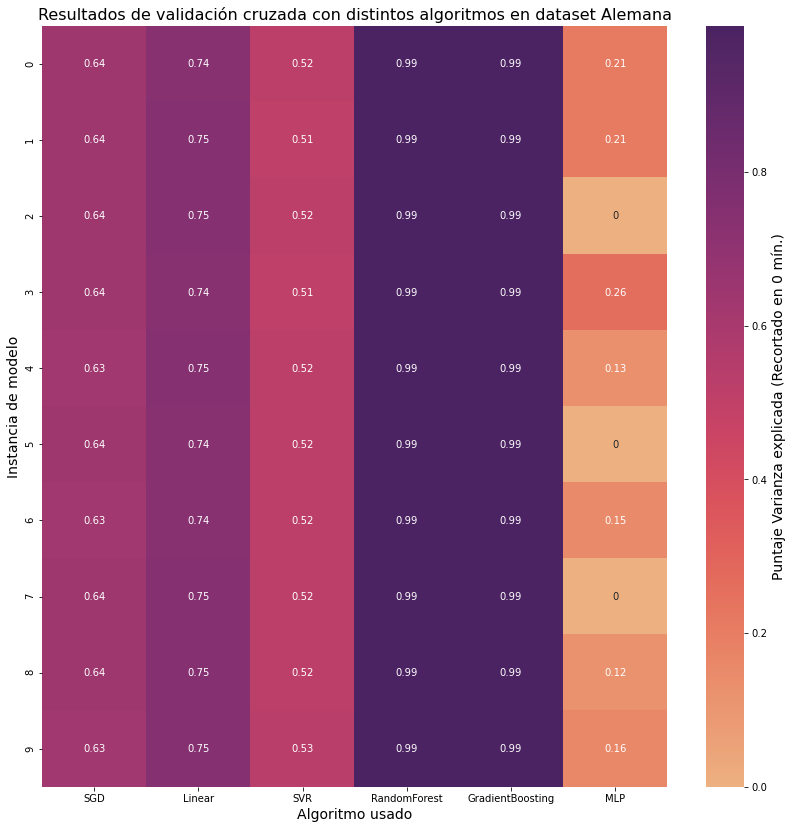

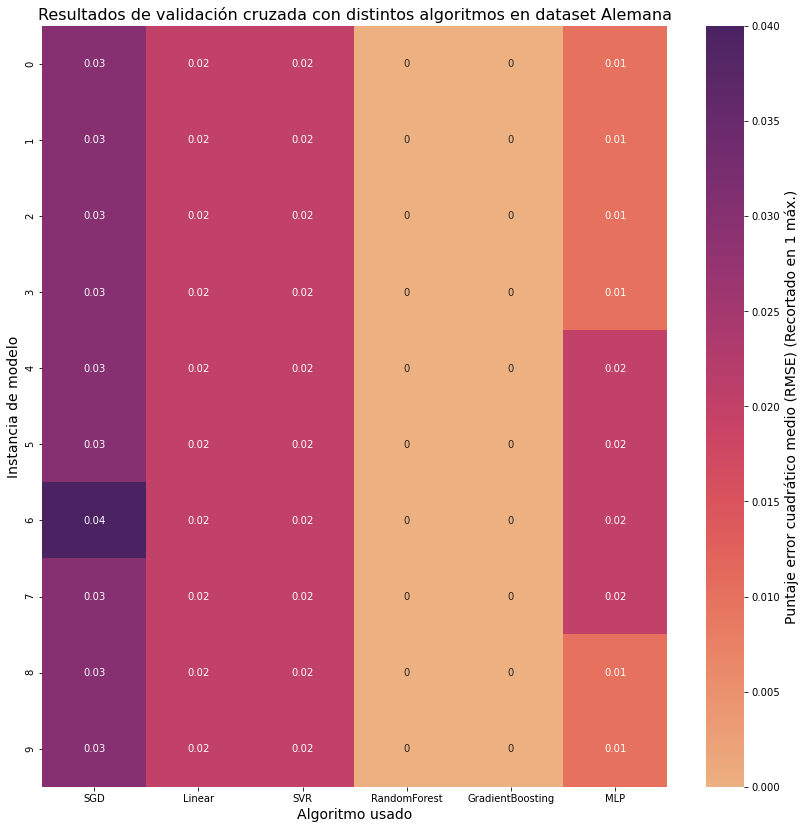

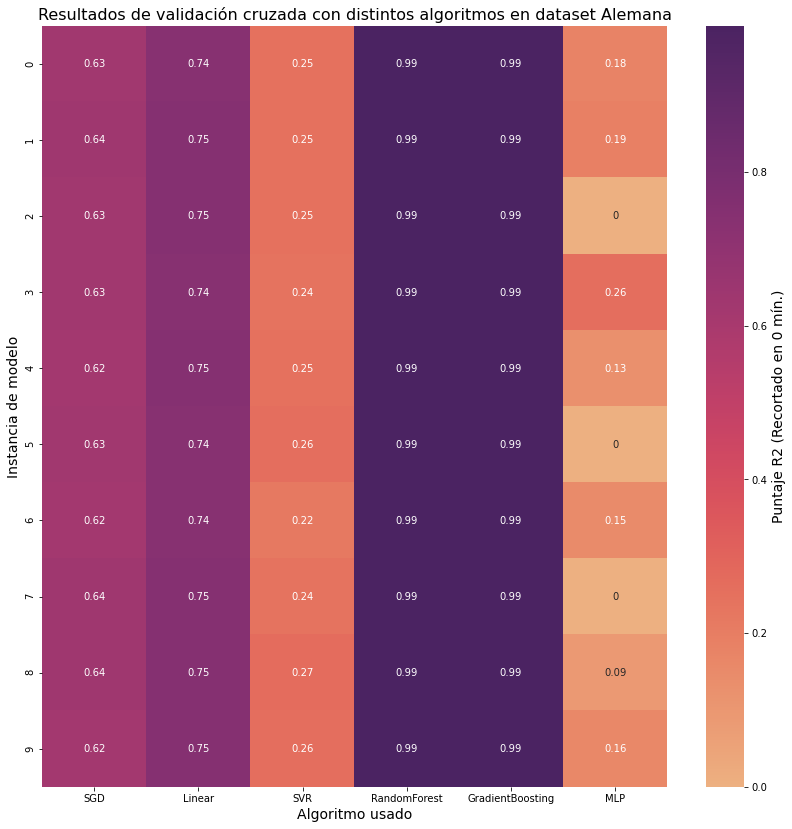

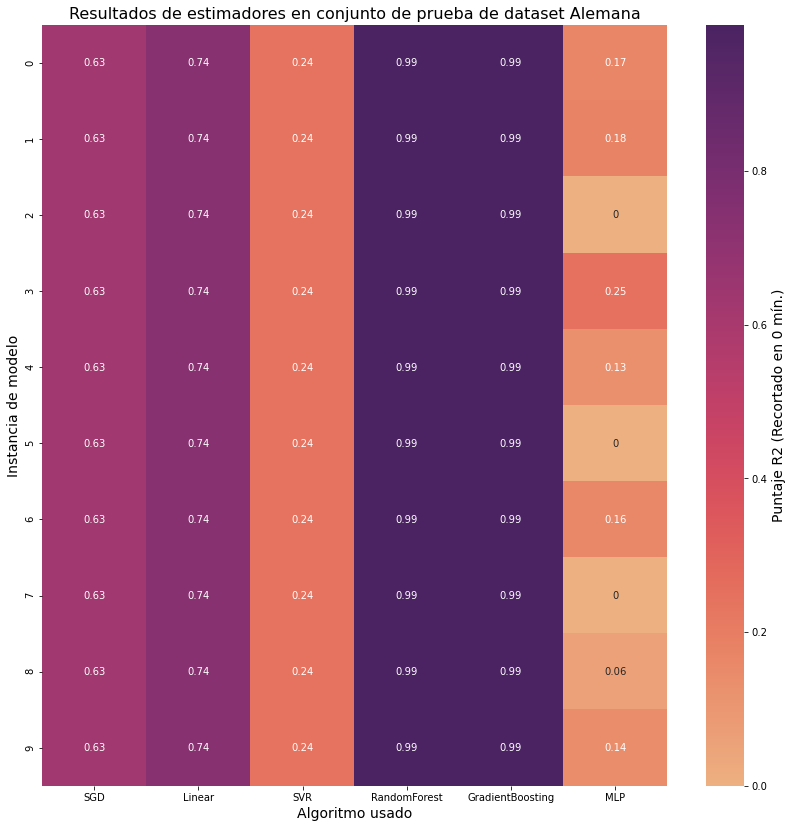

In [35]:
if SHOULD_SAMPLE:
    dataset = df.sample(frac=SAMPLE_PER, random_state = RAND_STATE)
else:
    dataset = df

# Shuffle dataset
dataset = dataset.sample(frac=1, random_state=RAND_STATE).reset_index(drop=True)

X = dataset.drop(columns=['Date', 'renewable', 'cost', 'losses']).drop(columns=[x for x in dataset.columns if 'terminal' in x])
y = dataset[['losses', 'renewable', 'cost']]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X, X_test, y, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)

# Hacer kfold, shuffle dataset
cv = KFold(n_splits=N_FOLDS, random_state=RAND_STATE, shuffle=True)

model_scores = {}

if POST_GS:
    for key, estimator in estimators.items():
        model_scores[key] = cross_validate(estimator, X, y, cv=cv, scoring=('explained_variance', 'neg_mean_squared_error', 'r2'), n_jobs=-1, return_estimator=True)
    
    save_to_pickle('{}_Opt_Score.pickle'.format(DATASET_NAME), model_scores)

else:
    model_scores = load_pickle('{}_Opt_Score.pickle'.format(DATASET_NAME)) 

model_scores_df =  pd.DataFrame.from_dict(model_scores).drop('estimator')
model_scores_df = model_scores_df.apply(lambda x: x.apply(lambda y: np.mean(y)), axis=1)

filter = {}
cv_scores = {}
test_keys = []
model_keys = list(model_scores.keys())

for key, item in model_scores.items():
    item_keys = [x for x in item.keys() if 'test' in x]
    test_keys = item_keys
    filter[key] = {}
    for ikey in item_keys:
        filter[key][ikey] = item[ikey]

for test in test_keys:
    cv_scores[test] = {}
    for model in model_keys:
        cv_scores[test][model] = filter[model][test]

test_scores = {}

for key, item in model_scores.items():
    test_scores[key] = list()
    for estimator in model_scores[key]['estimator']:
        test_scores[key].append(estimator.score(X_test, y_test))

test_label_dict = {'test_explained_variance': 'Puntaje Varianza explicada (Recortado en 0 mín.)',
                'test_neg_mean_squared_error': 'Puntaje error cuadrático medio (RMSE) (Recortado en 1 máx.)',
                'test_r2': 'Puntaje R2 (Recortado en 0 mín.)'}

for test, results in cv_scores.items():
    fig, ax = plt.subplots(figsize=(14, 14))
    fig_df = pd.DataFrame.from_dict(results)

    if 'neg' in test:
        fig_df = fig_df.apply(lambda x: x.apply(lambda y: -y))

    ax = sns.heatmap(fig_df.clip(lower=0, upper=1).round(decimals=2), annot = True, cmap=sns.color_palette('flare', as_cmap=True), cbar_kws={'label': test_label_dict[test]})
    ax.set_title('Resultados de validación cruzada con distintos algoritmos en dataset {}'.format(DATASET_NAME), fontsize = 16)
    ax.set_xlabel('Algoritmo usado', fontsize = 14)
    ax.set_ylabel('Instancia de modelo', fontsize = 14)
    ax.figure.axes[-1].yaxis.label.set_size(14)

    plt.show()

test_scores_df = pd.DataFrame.from_dict(test_scores)

fig, ax = plt.subplots(figsize=(14, 14))

ax = sns.heatmap(test_scores_df.clip(lower=0, upper=1).round(decimals=2), annot = True, cmap=sns.color_palette('flare', as_cmap=True), cbar_kws={'label': 'Puntaje R2 (Recortado en 0 mín.)'})
ax.set_title('Resultados de estimadores en conjunto de prueba de dataset {}'.format(DATASET_NAME), fontsize = 16)
ax.set_xlabel('Algoritmo usado', fontsize = 14)
ax.set_ylabel('Instancia de modelo', fontsize = 14)
ax.figure.axes[-1].yaxis.label.set_size(14)

plt.show()


In [36]:
model_scores['RandomForest']['estimator'][3]

RandomForestRegressor(n_estimators=10, random_state=42)

In [37]:
#import matplotlib.pyplot as plt
#from sklearn import tree

#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20,20), dpi=800)
#tree.plot_tree(model_scores['RandomForest']['estimator'][3].estimators_[0], filled = True);

#fig.show()

## Interpretabilidad

In [38]:
X_cols = list(dataset.drop(columns=['Date', 'renewable', 'cost', 'losses']).drop(columns=[x for x in dataset.columns if 'terminal' in x]).columns)
X_cols.append('losses')
X_cols.append('renewable')
col_length = len(X_cols)

### Linear

In [39]:
# modelo linear, importancia de atributos

linear_estimator = model_scores['Linear']['estimator'][0]
linear_estimator.estimators_[0].coef_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [40]:
pad_coefs = list()
for estimator in linear_estimator.estimators_:
    pad_coefs.append(np.pad(estimator.coef_, (0, col_length - len(estimator.coef_)), mode='constant', constant_values=0))


Se considera el orden de magnitud de cada coeficiente para comparar la relevancia de cada atributo. Se considera que el atributo no tiene relevancia para la predicción si el orden de magnitud es menor que cero.

In [41]:
linear_coefs_df = pd.DataFrame(pad_coefs, columns=X_cols).T.set_axis(['losses', 'renewable', 'cost'], axis=1, inplace=False)
linear_coefs_df = linear_coefs_df.apply(lambda x: np.log10(np.maximum(np.abs(x), 1)))
linear_coefs_df

,losses,renewable,cost
Load Farm voltage,0.0000,10.7139,8.7065
Load Industry voltage,0.0000,0.0000,0.0000
Load Market voltage,0.0000,11.5722,10.0859
Load Residential Complex voltage,0.0000,10.7639,9.5458
ConventionalGenerator Diesel Engine cst_disp,0.0000,1.3917,0.0000
ConventionalGenerator Diesel Engine loading,0.0000,0.1778,0.0000
ConventionalGenerator Diesel Engine pini,0.0000,11.6643,10.0051
ConventionalGenerator Diesel Engine voltage,0.0000,10.1144,8.3389
RenewableGenerator Battery Energy Storing System pini,0.0000,11.3382,9.6846
RenewableGenerator Battery Energy Storing System voltage,0.0000,11.8102,8.1048


### Random Forest

In [42]:
X_cols = list(dataset.drop(columns=['Date', 'renewable', 'cost', 'losses']).drop(columns=[x for x in dataset.columns if 'terminal' in x]).columns)

In [43]:
rforest_estimator = model_scores['RandomForest']['estimator'][0]
rforest_estimator.feature_importances_

array([4.19882279e-04, 6.78310191e-08, 5.66194985e-03, 3.12735606e-02,
       9.90510626e-02, 2.38128186e-02, 1.40202645e-01, 0.00000000e+00,
       1.14188719e-02, 9.67555778e-02, 1.34184640e-02, 4.05978921e-07,
       1.34379797e-01, 3.79949105e-07, 1.39021655e-04, 3.06103981e-03,
       2.61911539e-03, 2.66648176e-02, 2.16287878e-02, 4.04025467e-02,
       2.60985049e-02, 4.17409581e-03, 8.66060972e-04, 9.59446770e-03,
       5.50126048e-03, 4.35155835e-03, 9.65274716e-02, 1.09591528e-02,
       4.04881702e-04, 6.90957102e-03, 4.20229134e-07, 1.12893265e-01,
       0.00000000e+00, 2.56270194e-02, 1.23446304e-02, 3.28368268e-02])

Se considera importancia de cada atributo. Mientras mayor el valor, más importante es. Este valor corresponde a Gini Importance / Mean Decrease in Impurity (MDI)

In [44]:
#linear_coefs_df = pd.DataFrame(pad_coefs, columns=X_cols).T.set_axis(['losses', 'renewable', 'cost'], axis=1, inplace=False)
forest_importance_df = pd.DataFrame([rforest_estimator.feature_importances_], columns=X_cols).T
forest_importance_df

,0
Load Farm voltage,0.0004
Load Industry voltage,0.0000
Load Market voltage,0.0057
Load Residential Complex voltage,0.0313
ConventionalGenerator Diesel Engine cst_disp,0.0991
ConventionalGenerator Diesel Engine loading,0.0238
ConventionalGenerator Diesel Engine pini,0.1402
ConventionalGenerator Diesel Engine voltage,0.0000
RenewableGenerator Battery Energy Storing System pini,0.0114
RenewableGenerator Battery Energy Storing System voltage,0.0968


Debido a la diferencia de ordenes de magnitud en la importancia que se le otroga a cada atributo, se hace esta comparación también. Valores mayores son mejores.

In [45]:
forest_importance_magnitude_df = forest_importance_df.apply(lambda x: np.log10(np.abs(x)))
forest_importance_magnitude_df

C:\Users\sebca\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,0
Load Farm voltage,-3.3769
Load Industry voltage,-7.1686
Load Market voltage,-2.2470
Load Residential Complex voltage,-1.5048
ConventionalGenerator Diesel Engine cst_disp,-1.0041
ConventionalGenerator Diesel Engine loading,-1.6232
ConventionalGenerator Diesel Engine pini,-0.8532
ConventionalGenerator Diesel Engine voltage,-inf
RenewableGenerator Battery Energy Storing System pini,-1.9424
RenewableGenerator Battery Energy Storing System voltage,-1.0143


### Gradient Boosting

In [46]:
X_cols = list(dataset.drop(columns=['Date', 'renewable', 'cost', 'losses']).drop(columns=[x for x in dataset.columns if 'terminal' in x]).columns)
X_cols.append('losses')
X_cols.append('renewable')
col_length = len(X_cols)

In [47]:
gboost_estimator = model_scores['GradientBoosting']['estimator'][1]
gboost_estimator.estimators_[2].feature_importances_

array([5.00223939e-05, 1.22905120e-03, 1.76709926e-03, 6.95935280e-03,
       5.83219501e-03, 6.69634609e-01, 4.85881740e-03, 0.00000000e+00,
       2.16221169e-02, 7.77376212e-03, 1.07263563e-01, 2.12126221e-03,
       9.81865754e-05, 8.12715377e-04, 1.75245455e-03, 0.00000000e+00,
       1.62993150e-03, 1.43413269e-03, 2.38881007e-03, 3.93995466e-04,
       3.29096033e-03, 3.88277153e-04, 7.03618187e-03, 2.94011842e-03,
       7.90907928e-04, 3.02822920e-03, 1.75177441e-03, 3.83161635e-03,
       5.05071253e-04, 5.42099827e-05, 8.82229807e-04, 1.73484591e-03,
       0.00000000e+00, 1.18819598e-01, 9.89707506e-03, 7.42682734e-03,
       0.00000000e+00, 0.00000000e+00])

In [48]:
pad_coefs = list()
for estimator in gboost_estimator.estimators_:
    pad_coefs.append(np.pad(estimator.feature_importances_, (0, col_length - len(estimator.feature_importances_)), mode='constant', constant_values=0))

In [49]:
gboost_coefs_df = pd.DataFrame(pad_coefs, columns=X_cols).T.set_axis(['losses', 'renewable', 'cost'], axis=1, inplace=False)
gboost_coefs_df

,losses,renewable,cost
Load Farm voltage,0.0000,0.0000,0.0001
Load Industry voltage,0.0000,0.0000,0.0012
Load Market voltage,0.0000,0.0010,0.0018
Load Residential Complex voltage,0.0000,0.0142,0.0070
ConventionalGenerator Diesel Engine cst_disp,0.0000,0.2355,0.0058
ConventionalGenerator Diesel Engine loading,0.0000,0.0810,0.6696
ConventionalGenerator Diesel Engine pini,0.0000,0.0148,0.0049
ConventionalGenerator Diesel Engine voltage,0.0000,0.0000,0.0000
RenewableGenerator Battery Energy Storing System pini,0.0000,0.0279,0.0216
RenewableGenerator Battery Energy Storing System voltage,0.0000,0.2517,0.0078


### Stochastic Gradient Descent

In [50]:
X_cols = list(dataset.drop(columns=['Date', 'renewable', 'cost', 'losses']).drop(columns=[x for x in dataset.columns if 'terminal' in x]).columns)
X_cols.append('losses')
X_cols.append('renewable')
col_length = len(X_cols)

In [51]:
sgd_estimator = model_scores['SGD']['estimator'][0]
sgd_estimator.estimators_[0].coef_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [52]:
pad_coefs = list()
for estimator in sgd_estimator.estimators_:
    pad_coefs.append(np.pad(estimator.coef_, (0, col_length - len(estimator.coef_)), mode='constant', constant_values=0))

In [53]:
sgd_coefs_df = pd.DataFrame(pad_coefs, columns=X_cols).T.set_axis(['losses', 'renewable', 'cost'], axis=1, inplace=False)
sgd_coefs_df

,losses,renewable,cost
Load Farm voltage,0.0000,-0.0200,-0.0018
Load Industry voltage,0.0000,-0.0210,0.0016
Load Market voltage,0.0000,-0.0606,-0.0002
Load Residential Complex voltage,0.0000,0.0000,-0.0007
ConventionalGenerator Diesel Engine cst_disp,0.0000,-0.0297,0.0000
ConventionalGenerator Diesel Engine loading,0.0000,-0.3201,0.0000
ConventionalGenerator Diesel Engine pini,0.0000,-0.0701,0.0000
ConventionalGenerator Diesel Engine voltage,0.0000,0.0000,0.0000
RenewableGenerator Battery Energy Storing System pini,0.0000,0.0208,-0.0002
RenewableGenerator Battery Energy Storing System voltage,0.0000,0.0261,0.0001
